In [1]:
import json
import pickle
import pprint
import dateutil
import datetime
import os

import numpy as np
import pandas as pd
import requests
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

## constants

In [2]:
## paths
CACHE_PATH = 'script-data/'

## api endpoints
LISTINGS_URL = 'https://dev.repliers.io/listings'
LISTINGS_LOCATIONS_URL = 'https://dev.repliers.io/listings/locations'

## request headers
HEADERS = { 'REPLIERS-API-KEY': '1234567890',
            'content-type': 'application/json' }

## condo details

## menkes
SHERWAY_GARDENS = [{ 'streetName': 'Sherway Gardens', 'streetNumber': 205, 'type': 'sale' }]
GIBSON_SQUARE = [{ 'streetName': 'Yonge', 'streetNumber': 5162, 'type': 'sale' },
                 { 'streetName': 'Yonge', 'streetNumber': 5168, 'type': 'sale' }]
PEARS_ON_THE_AVENUE = [{ 'streetName': 'Avenue', 'streetNumber': 162, 'type': 'sale' },
                       { 'streetName': 'Avenue', 'streetNumber': 170, 'type': 'sale' }]
FABRIK = [{ 'streetName': 'Richmond', 'streetNumber': 435, 'type': 'sale' }]

## tridel
SQ = [{ 'streetName': 'Cameron', 'streetNumber': 38, 'type': 'sale' }]
AQUAVISTA = [{ 'streetName': 'Queens Quay', 'streetNumber': 261, 'type': 'sale' }]
AQUALINA = [{ 'streetName': 'Merchants\' Wharf', 'streetNumber': 15, 'type': 'sale' }]
FRONT_300 = [{ 'streetName': 'Front', 'streetNumber': 300, 'type': 'sale' }]
ALTER = [{ 'streetName': 'Mcgill', 'streetNumber': 89, 'type': 'sale' }]
ERSKINE_101 = [{ 'streetName': 'Erskine', 'streetNumber': 101, 'type': 'sale' }]


## local cache-related params
LISTINGS_CACHE_INSTRUCTIONS = [ (SHERWAY_GARDENS, 'u-listings-sherway.pickle', 'menkes'),
                                (GIBSON_SQUARE, 'u-listings-gibson.pickle', 'menkes'),
                                (PEARS_ON_THE_AVENUE, 'u-listings-pears.pickle', 'menkes'),
                                (FABRIK, 'u-listings-fabrik.pickle', 'menkes'),
                                (SQ, 'u-listings-gibson.pickle', 'tridel'),
                                (AQUAVISTA, 'u-listings-aquavista.pickle', 'tridel'),
                                (AQUALINA, 'u-listings-aqualina.pickle', 'tridel'),
                                (FRONT_300, 'u-listings-300-front.pickle', 'tridel'),
                                (ALTER, 'u-listings-alter.pickle', 'tridel'),
                                (ERSKINE_101, 'u-listings-101-erskine.pickle', 'tridel')]
LISTINGS_CACHE_ELEMS = [ (x[1], x[2]) for x in LISTINGS_CACHE_INSTRUCTIONS ]

## convenience functions

In [3]:
def save(obj, fname='cache.pickle'):
    pickle.dump(obj, open('%s/%s' % (CACHE_PATH, fname), "wb"))

def load(fname='cache.pickle'):
    return pickle.load(open('%s/%s' % (CACHE_PATH, fname), "rb"))

def print_nicely(txt, use_pprint=False):
    if use_pprint:
        pprint.pprint(txt)
    else:
        print(json.dumps(txt, indent=4))

## raw data pipepline

In [4]:
def extract_locations():
    req = requests.get(LISTINGS_LOCATIONS_URL, headers=HEADERS)
    return req

def extract_listings(city='Toronto', status='U', params={}, to_json=True):
    if city is not None:
        params['city'] = city
        
    if status is not None:
        params['status'] = status
        
    req = requests.get(LISTINGS_URL, headers=HEADERS, params=params)
    
    if to_json:
        return json.loads(req.text)
    else:
        return req

def _raw_listings_etl(city='Toronto', status='U', params_list=[], stash_fname='cache.pickle'):
    if len(params_list) == 0:
        return False
    
    ## extract
    es = [ extract_listings(city=city, status=status, params=params) for params in params_list ]
    
    ## transform
    t = es[0]
    
    for e in es[1:]:
        t['listings'] = t['listings'] + e['listings']
        
    ## load
    save(t, fname=stash_fname)
    
    return True

def raw_listings_etl(city='Toronto', status='U', cache_instructions=[]):
    for (params_list, stash_fname, _) in cache_instructions:
        _raw_listings_etl(city=city, status=status, params_list=params_list, stash_fname=stash_fname)

## summary data pipeline

In [5]:
def transform_listings_to_summary(listings=[], builder=None):
    rows = []
    
    for listing in listings:
        if listing['lastStatus'] in ['Exp', 'Ter', 'Sus']:
            continue

        ## address
        street_number = listing['address']['streetNumber']
        street_name = listing['address']['streetName']
        street_suffix = listing['address']['streetSuffix']
        
        ## dates
        list_date = dateutil.parser.parse(listing['listDate'])
        sold_date = dateutil.parser.parse(listing['soldDate'])
        dom = int(listing['daysOnMarket'])
        computed_dom = (sold_date - list_date).days
        
        ## prices
        list_price = float(listing['listPrice'])
        sold_price = float(listing['soldPrice'])
        sold_list_difference = sold_price - list_price

        ## meta
        taxes = float(listing['taxes']['annualAmount'])
        
        ## bedrooms
        n_bedrooms = listing['details']['numBedrooms']
        n_bedrooms = 0 if (n_bedrooms is None) or (n_bedrooms == '') else float(n_bedrooms)
        
        n_bedrooms_plus = listing['details']['numBedroomsPlus']
        n_bedrooms_plus = 0 if (n_bedrooms_plus is None) or (n_bedrooms_plus == '') else (float(n_bedrooms_plus) / 2)
        
        n_bedrooms = n_bedrooms + n_bedrooms_plus

        ## bathrooms
        n_bathrooms = listing['details']['numBathrooms']
        n_bathrooms = 0 if (n_bathrooms is None) or (n_bathrooms == '') else float(n_bathrooms)
        
        n_bathrooms_plus = listing['details']['numBathroomsPlus']
        n_bathrooms_plus = 0 if (n_bathrooms_plus is None) or (n_bathrooms_plus == '') else (float(n_bathrooms_plus) / 2)
        
        n_bathrooms = n_bathrooms + n_bathrooms_plus

        ## add row
        rows.append({ 'street_number': street_number, 
                      'street_name': street_name, 
                      'street_suffix': street_suffix,
                      'builder': builder,
                      'list_date': list_date,
                      'sold_date': sold_date,
                      'dom': dom,
                      'computed_dom': computed_dom,
                      'list_price': list_price, 
                      'sold_price': sold_price, 
                      'sold_list_difference': sold_list_difference, 
                      'taxes': taxes, 
                      'n_bedrooms': n_bedrooms, 
                      'n_bathrooms': n_bathrooms })

    return pd.DataFrame(rows)
    
def _summary_listings_etl(stash_fname='cache.pickle', builder=None):
    cached_listings = load(fname=stash_fname)
    return transform_listings_to_summary(listings=cached_listings['listings'], builder=builder)

def summary_listings_etl(stash_elems=[]):
    ## extract
    es = [ _summary_listings_etl(stash_fname=stash_fname, builder=builder) for (stash_fname, builder) in stash_elems ]
    
    ## transform
    ts = []
    for t in es:
        ts.append(t)
        
    t = pd.concat(ts)
    
    return t.reset_index(drop=True)

## scripting

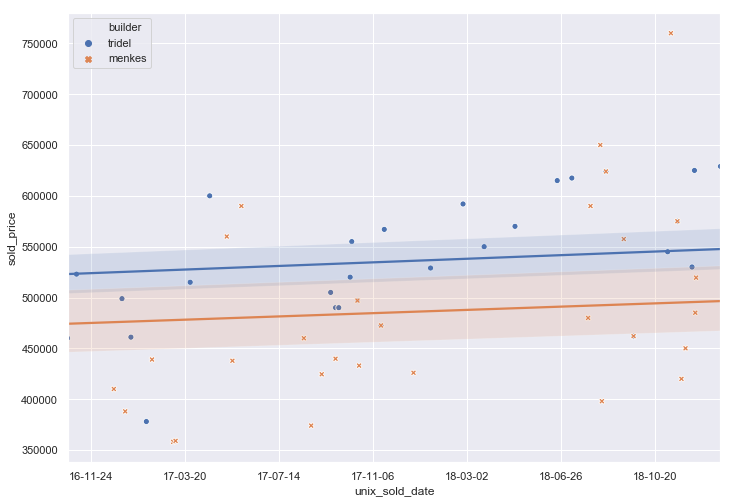

In [6]:
df = summary_listings_etl(LISTINGS_CACHE_ELEMS)
df = df.sort_values('sold_date')

df = df[(df['n_bedrooms'] == 1) & (df['n_bedrooms'] == 1)]

df['sold_date'] = df['sold_date'] + pd.to_timedelta(df.groupby('sold_date').cumcount(), unit='m')
df = df.set_index('sold_date', drop=False)

df['unix_sold_date'] = df['sold_date'].astype(np.int64)
df['mean_sold_price'] = df['sold_price'].rolling(25).mean()

fig, ax = plt.subplots(figsize=(11.7, 8.27))

ax = sns.scatterplot(ax=ax, x="unix_sold_date", y="sold_price", hue='builder', style='builder', data=df)
#ax = sns.lineplot(ax=ax, x="sold_date", y="mean_sold_price", data=df)
ax = sns.regplot(ax=ax, x="unix_sold_date", y="sold_price", scatter=False, data=df[df['builder'] == 'tridel'])
ax = sns.regplot(ax=ax, x="unix_sold_date", y="sold_price", scatter=False, data=df[df['builder'] == 'menkes'])

ax.set_xlim(df['unix_sold_date'].min(), df['unix_sold_date'].max())

labels = ax.get_xticks()
labels = [ int(l / 1000000000) for l in labels ]
#labels = [ item.get_text() for item in ax.get_xticks() ]
labels = [ datetime.datetime.utcfromtimestamp(ts).strftime('%y-%m-%d') for ts in labels ]
_ = ax.set_xticklabels(labels)

#print(df['sold_price'].rolling(3).mean())
#print(df['sold_price'])